In [116]:
# Notebook to read in the nexus files and try to smear the electron clouds from the MV hits
import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import re
from collections import Counter

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [117]:
# Load in the hits
hits = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb.h5", 'MC/hits')
parts = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb.h5", 'MC/particles')
# hits.z = hits.z+3000
display(hits)

,event_id,x,y,z,time,energy,label,particle_id,hit_id
0,0,-2463.465576,392.722473,853.506958,0.004292,0.000189,GAS,2,0
1,0,-2463.575195,392.519806,852.548035,0.008545,0.001784,GAS,2,1
2,0,-2463.724609,392.329681,851.592041,0.012804,0.000088,GAS,2,2
3,0,-2464.014893,392.134613,850.670105,0.017063,0.000639,GAS,2,3
4,0,-2464.322754,391.930878,849.755798,0.021324,0.000221,GAS,2,4
...,...,...,...,...,...,...,...,...,...
5673,0,-2466.654053,404.670197,919.405518,0.226819,0.000278,GAS,86,0
5674,0,-2466.688721,404.673401,919.398438,0.227734,0.001194,GAS,86,1
5675,0,-2466.690186,404.695190,919.391785,0.228423,0.000161,GAS,86,2
5676,0,-2466.688721,404.680298,919.406982,0.229083,0.001666,GAS,86,3


In [118]:
# Define a function to smear the geant4 electrons uniformly between the steps
# Each electron is sampled uniformly towards the previous hit
# The ends of the track are sampled in the backward direction only 
def generate_random(row):
    r0 = np.array([row['x'], row['y'], row['z']])
    r1 = np.array([row['x'] - row['dx'], row['y'] - row['dy'], row['z'] - row['dz']])  # Backward delta

    # Uniformly move backward from the hit by its step size
    random_number = rng.uniform(0, 1)
    new_r = r0 + random_number * (r1 - r0)

    # Apply diffusion if scaling is nonzero
    if diff_scaling != 0.0:
        z = new_r[2]  # mm
        sigma_DL = diff_scaling * DL * np.sqrt(z / 10.0)  # mm  
        sigma_DT = diff_scaling * DT * np.sqrt(z / 10.0)  # mm  

        mean = new_r
        cov = np.diag([sigma_DT**2, sigma_DT**2, sigma_DL**2])  # 3D covariance matrix

        new_r = rng.multivariate_normal(mean, cov)

    return pd.Series(new_r, index=['x_smear', 'y_smear', 'z_smear'])

In [119]:
binsize=20
diff_scaling = 1

percentage = 0.1

eid = 0

# The percentage 0 is actually a small amount
if (percentage == 0.05):
    DL = 0.05 # mm / sqrt(cm)
    DT = 0.05 # mm / sqrt(cm)
elif (percentage == 0.1):
    DL = 0.940 # mm / sqrt(cm)
    DT = 0.974 # mm / sqrt(cm)
elif (percentage == 0.25):
    DL = 0.703 # mm / sqrt(cm)
    DT = 0.517 # mm / sqrt(cm)
elif (percentage == 0.5):
    DL = 0.507 # mm / sqrt(cm)
    DT = 0.373 # mm / sqrt(cm)
elif (percentage == 5):
    DL = 0.290 # mm / sqrt(cm)
    DT = 0.279 # mm / sqrt(cm)
else:
    print("Error CO2 percentage not defined at 75 V/cm field")


z_shift = 3000
rng = np.random.default_rng()

# Create the bins ---- 
xbw=binsize
xmin=-3000 - binsize/2 
xmax=3000 + binsize/2

ybw=binsize
ymin=-3000 - binsize/2 
ymax=3000 + binsize/2


# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = 3000
print("z_shift is:", z_shift)
# z_shift = 0

zbw=binsize
zmin=-3000 + z_shift - binsize/2 
zmax=3000 + z_shift + binsize/2


# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2


# Mean energy per e-. This splits up each G4 into E_hit/E_mean electrons
E_mean = 25e-6 # [eV]

z_shift is: 3000


In [120]:
# Select the event
event = hits[hits.event_id == eid]
event_part = parts[parts.event_id == eid]

# Shift z-values so 0 is at the anode
event.z = event.z+z_shift

# Calc number of electrons in a hit
event["n"] = round(event["energy"]/E_mean)

display(event)
display(event_part)
print(event.energy.sum())
print(event.n.sum())

,event_id,x,y,z,time,energy,label,particle_id,hit_id,n
0,0,-2463.465576,392.722473,3853.506836,0.004292,0.000189,GAS,2,0,8.0
1,0,-2463.575195,392.519806,3852.548096,0.008545,0.001784,GAS,2,1,71.0
2,0,-2463.724609,392.329681,3851.592041,0.012804,0.000088,GAS,2,2,4.0
3,0,-2464.014893,392.134613,3850.670166,0.017063,0.000639,GAS,2,3,26.0
4,0,-2464.322754,391.930878,3849.755859,0.021324,0.000221,GAS,2,4,9.0
...,...,...,...,...,...,...,...,...,...,...
5673,0,-2466.654053,404.670197,3919.405518,0.226819,0.000278,GAS,86,0,11.0
5674,0,-2466.688721,404.673401,3919.398438,0.227734,0.001194,GAS,86,1,48.0
5675,0,-2466.690186,404.695190,3919.391846,0.228423,0.000161,GAS,86,2,6.0
5676,0,-2466.688721,404.680298,3919.406982,0.229083,0.001666,GAS,86,3,67.0


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,2,e-,1,0,-2463.387939,393.043365,854.445801,0.000000,-2477.623291,...,-0.051506,-0.285778,-0.552063,-0.0,0.0,-0.0,0.295361,302.505341,none,eIoni
1,0,77,e-,0,2,-2477.602783,412.750854,884.984924,1.489045,-2477.602539,...,0.000883,0.003227,0.003133,0.0,0.0,0.0,0.000021,0.001905,eIoni,eIoni
2,0,76,e-,0,2,-2477.602783,412.750854,884.984924,1.489045,-2477.602783,...,-0.002517,-0.000643,-0.003777,-0.0,-0.0,-0.0,0.000021,0.000239,eIoni,msc
3,0,75,e-,0,2,-2477.602783,412.750854,884.984924,1.489045,-2477.603027,...,-0.003348,-0.000813,-0.005916,0.0,0.0,-0.0,0.000046,0.000370,eIoni,msc
4,0,74,e-,0,2,-2477.602783,412.750854,884.984924,1.489045,-2477.602783,...,-0.000253,0.002260,0.004236,-0.0,0.0,-0.0,0.000023,0.000745,eIoni,msc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,0,651,e-,0,89,-2458.761230,432.820068,1029.311646,0.628000,-2458.760010,...,0.012495,-0.011973,0.012636,-0.0,-0.0,0.0,0.000449,0.013014,eIoni,eIoni
662,0,650,e-,0,89,-2458.761230,432.820068,1029.311646,0.628000,-2458.761719,...,0.000927,-0.002173,-0.015421,-0.0,-0.0,-0.0,0.000238,0.006162,eIoni,eIoni
663,0,88,e-,0,1,-2464.468262,420.749084,999.351501,0.506667,-2464.485596,...,-0.017685,-0.036048,0.013337,-0.0,0.0,0.0,0.001749,0.076292,eIoni,eIoni
664,0,87,e-,0,1,-2468.337891,408.893677,955.505920,0.350711,-2468.326660,...,0.035111,0.010995,0.000456,-0.0,0.0,0.0,0.001323,0.027725,eIoni,eIoni


2.4578302
98339.0


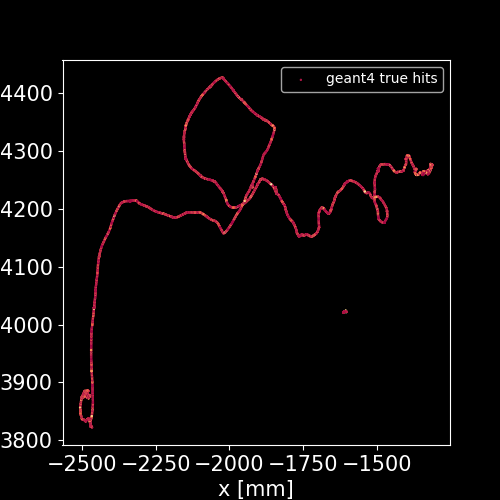

In [121]:
# Plot the event
%matplotlib widget
# Make a 3D view of the track
fig  = plt.figure(figsize=(5, 5))

# event_hits = event_hits[event_hits.particle_id == 579]
# display(event_hits)

# Create 3D axes
ax = fig.add_subplot(111)

fig.set_facecolor('black')
ax.set_facecolor('black')
# ax.scatter(df.x, df.y,  df.z,c= df.energy, cmap='Spectral', s=0.1, label = "reco hits")
ax.scatter(event.x, event.z,c= event.energy, cmap='Spectral', s=0.5, label = "geant4 true hits")

ax.set_xlabel("x [mm]", fontsize = 15)
ax.set_ylabel("y [mm]", fontsize = 15)
# ax.set_zlabel("z [mm]", fontsize = 15)
plt.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
# ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
# ax.tick_params(axis='z', colors='white')

# Set the color of the spines (borders) to white
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')


legend = plt.legend(facecolor = "black")

# Set the text color of the legend
for text in legend.get_texts():
    text.set_color('white')  # Set the text color to red

- Sort by particle id
- Sort by time

In [122]:
df_smear = []


# Loop over the particles and get the differences between steps ------
particles = event.particle_id.unique()

smear_df = []

for idx, p in enumerate(particles):

    # Get hits for particle i in the event
    temp_part_hits = event[event.particle_id == p]
    temp_part = event_part[event_part.particle_id == p]
    particle_name = temp_part.particle_name.iloc[0]

    nrows = len(temp_part_hits)

    # This dataframe contains the difference in distance between hits
    diff_df = temp_part_hits[['x', 'y', 'z']].diff()

    # Set the dist for the first hit as the difference to the inital position
    diff_df.iloc[0, diff_df.columns.get_loc('x')] = temp_part_hits.iloc[0].x - temp_part.initial_x.iloc[0]
    diff_df.iloc[0, diff_df.columns.get_loc('y')] = temp_part_hits.iloc[0].y - temp_part.initial_y.iloc[0]
    diff_df.iloc[0, diff_df.columns.get_loc('z')] = temp_part_hits.iloc[0].z - (temp_part.initial_z.iloc[0]+z_shift)

    # Name the columns by their deltas
    diff_df = diff_df.rename(columns={'x': 'dx', 'y': 'dy', 'z': 'dz'})

    # We dont want to smear over the gamma steps
    # Only their daughter electrons
    if (particle_name == "gamma"):
        diff_df["dx"] = 0*diff_df["dx"]
        diff_df["dy"] = 0*diff_df["dy"]
        diff_df["dz"] = 0*diff_df["dz"]
    
    smear_df.append(diff_df)

# Concatenate DataFrames along rows (axis=0)
smear_df = pd.concat(smear_df)

# Now merge to the main df
event = pd.merge(event, smear_df, left_index=True, right_index=True, how='inner')

# Create a new DataFrame with duplicated rows, so we can smear each electron by diffusion
electrons = pd.DataFrame(np.repeat(event[["event_id",'x', 'y', 'z', 'dx', 'dy', 'dz']].values, event['n'], axis=0), columns=["event_id",'x', 'y', 'z', 'dx', 'dy', 'dz'])

# Reset the index of the new DataFrame if needed
electrons = electrons.reset_index(drop=True)

# Now apply some smearing to each of the electrons
# Apply the function to create new columns
new_columns     = electrons.apply(generate_random, axis=1)
electrons_smear = pd.concat([electrons, new_columns], axis=1)
electrons_smear["energy"] = E_mean # MeV

# We need to set this to make sure we keep the information about the unbinned positions in the weighting
electrons_smear['x'] = electrons_smear['x_smear']
electrons_smear['y'] = electrons_smear['y_smear']
electrons_smear['z'] = electrons_smear['z_smear']

# Now lets bin the data
electrons_smear['x_smear'] = pd.cut(x=electrons_smear['x_smear'], bins=xbins,labels=xbin_c, include_lowest=True)
electrons_smear['y_smear'] = pd.cut(x=electrons_smear['y_smear'], bins=ybins,labels=ybin_c, include_lowest=True)
electrons_smear['z_smear'] = pd.cut(x=electrons_smear['z_smear'], bins=zbins,labels=zbin_c, include_lowest=True)

# Loop over the rows in the dataframe and sum the energies of all electrons in a bin. 
# Also change the bin center to use the mean x,y,z position
x_mean_arr = []
y_mean_arr = []
z_mean_arr = []
energy_mean_arr = []
x_mean_arr_temp = np.array([])
y_mean_arr_temp = np.array([])
z_mean_arr_temp = np.array([])
summed_energy = 0
event_id = 0

counter = 0

# Sort so all the bin labels are next to one another
electrons_smear = electrons_smear.sort_values(by=['x_smear', 'y_smear', 'z_smear'])


# This method seems slow...
# electrons_smear = electrons_smear.groupby(['event_id', 'x_smear', 'y_smear', 'z_smear']).agg({
#     'x': 'mean',
#     'y': 'mean',
#     'z': 'mean',
#     'energy': 'sum'
# }).reset_index()
# electrons_smear = electrons_smear.dropna()

# Loop over all bins and aggregate to get total energy in each bin and their
# mean x,y,z position
for index, row in electrons_smear.iterrows():

    # First row 
    if (counter == 0):
        temp_x = row["x_smear"]
        temp_y = row["y_smear"]
        temp_z = row["z_smear"]
        summed_energy +=row["energy"]
        event_id = row["event_id"]
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        counter+=1
        continue

    # Final row
    if index == electrons_smear.index[-1]:
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        summed_energy +=row["energy"]

        if (summed_energy != 0): 
            x_mean_arr = np.append(x_mean_arr,np.mean(x_mean_arr_temp))
            y_mean_arr = np.append(y_mean_arr,np.mean(y_mean_arr_temp))
            z_mean_arr = np.append(z_mean_arr,np.mean(z_mean_arr_temp))
            energy_mean_arr.append(summed_energy)


    # Same bin
    if (row["x_smear"] == temp_x and row["y_smear"] == temp_y and row["z_smear"] == temp_z):
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        summed_energy +=row["energy"]

    # Aggregate and store for next 
    else:
        if (summed_energy != 0): 
            x_mean_arr = np.append(x_mean_arr,np.mean(x_mean_arr_temp))
            y_mean_arr = np.append(y_mean_arr,np.mean(y_mean_arr_temp))
            z_mean_arr = np.append(z_mean_arr,np.mean(z_mean_arr_temp))
            energy_mean_arr.append(summed_energy)
        
        temp_x = row["x_smear"]
        temp_y = row["y_smear"]
        temp_z = row["z_smear"]
        summed_energy = 0
        x_mean_arr_temp = np.array([])
        y_mean_arr_temp = np.array([])
        z_mean_arr_temp = np.array([])
        
        
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        summed_energy +=row["energy"]
        

    counter+=1

events = np.ones_like(energy_mean_arr)*0

# Make the dataframe again
electrons_smear = pd.DataFrame({  "event_id" : events, "x" : x_mean_arr,  "y" : y_mean_arr,  "z" : z_mean_arr,  "energy" : energy_mean_arr  }) 


# File writing
electrons_smear = electrons_smear.sort_values(by=['event_id', 'z', 'x', 'y'])

electrons_smear['event_id'] = electrons_smear['event_id'].astype(int)
electrons_smear['z'] = electrons_smear['z'].astype('float32')
electrons_smear['x'] = electrons_smear['x'].astype('float32')
electrons_smear['y'] = electrons_smear['y'].astype('float32')
# df['energy'] = df['energy']*1e6
electrons_smear['energy'] = electrons_smear['energy'].astype('float32')

df_smear.append(electrons_smear)


df_smear_merge = pd.concat(df_smear, ignore_index=True)


In [123]:
display(df_smear_merge)
print(df_smear_merge.energy.sum())

,event_id,x,y,z,energy
0,0,-2490.276367,326.349792,3756.712158,0.000025
1,0,-2458.630615,366.866211,3762.743652,0.000025
2,0,-2497.670410,339.824341,3779.790771,0.000050
3,0,-2497.636475,383.318695,3781.324463,0.000075
4,0,-2440.458252,375.929565,3781.609375,0.000075
...,...,...,...,...,...
5441,0,-2013.807495,687.317444,4473.334473,0.000025
5442,0,-2004.901367,676.213013,4474.134766,0.000025
5443,0,-2040.290283,693.857422,4474.736328,0.000025
5444,0,-2015.985840,665.938110,4477.028809,0.000075


2.4585252


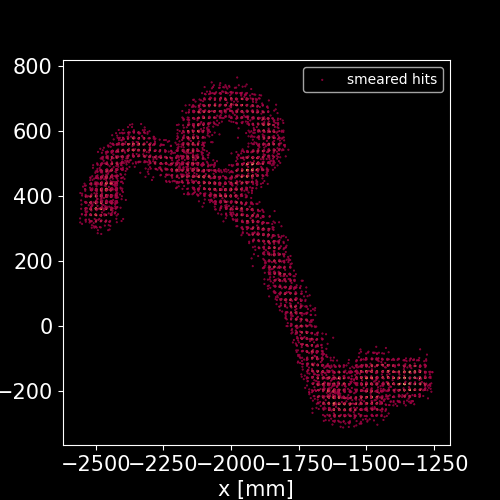

In [124]:
# Plot the event
# Make a 3D view of the track
fig  = plt.figure(figsize=(5, 5))

# event_hits = event_hits[event_hits.particle_id == 579]
# display(event_hits)

# Create 3D axes
ax = fig.add_subplot(111)

fig.set_facecolor('black')
ax.set_facecolor('black')
ax.scatter(df_smear_merge.x, df_smear_merge.y,c= df_smear_merge.energy, cmap='Spectral', s=0.25, label = "smeared hits")
# ax.scatter(df.x, df.z,c= "white", s=1, label = "true hits")

ax.set_xlabel("x [mm]", fontsize = 15)
ax.set_ylabel("y [mm]", fontsize = 15)
# ax.set_zlabel("z [mm]", fontsize = 15)
plt.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
# ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
# ax.tick_params(axis='z', colors='white')

# Set the color of the spines (borders) to white
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')



legend = plt.legend(facecolor = "black")

# Set the text color of the legend
for text in legend.get_texts():
    text.set_color('white')  # Set the text color to red

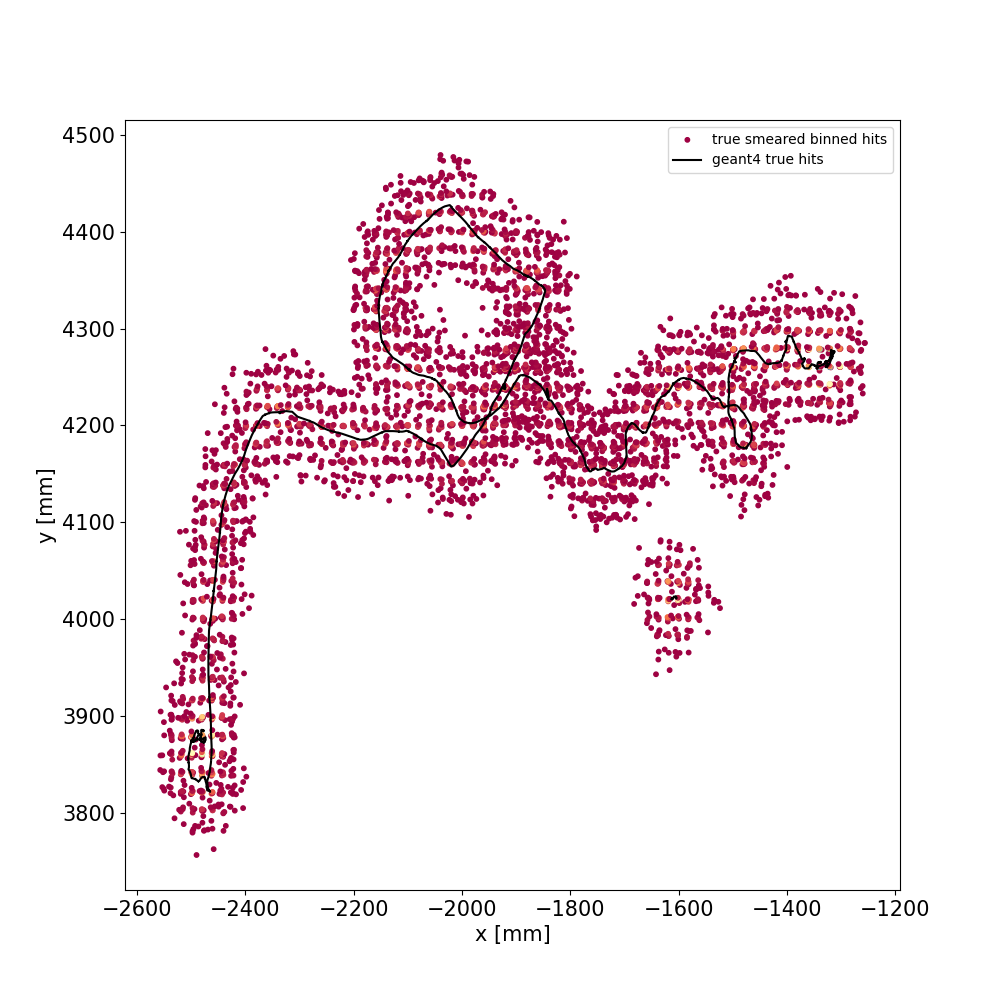

In [125]:
# Plot the event
# Make a 3D view of the track
fig  = plt.figure(figsize=(10, 10))

df = hits[hits.event_id == eid]
df["z"] = df["z"]+3000
# event_hits = event_hits[event_hits.particle_id == 579]
# display(event_hits)

# Create 3D axes
ax = fig.add_subplot(111)

# fig.set_facecolor('black')
# ax.set_facecolor('black')
# df_smear_merge=df_smear_merge[df_smear_merge.energy > 0.0001]
ax.scatter(df_smear_merge.x, df_smear_merge.z,c= df_smear_merge.energy, cmap='Spectral', s=10, label = "true smeared binned hits")
# ax.scatter(event_hits.x, event_hits.z,c= event_hits.energy, cmap='Spectral', s=0.5, label = "geant4 true hits")

for index, p in enumerate(df.particle_id.unique()):
    if (index == 0):
        ax.plot(df[df.particle_id == p].x, df[df.particle_id == p].z,c= "black", label = "geant4 true hits")
    else:
        ax.plot(df[df.particle_id == p].x, df[df.particle_id == p].z,c= "black")

ax.set_xlabel("x [mm]", fontsize = 15)
ax.set_ylabel("y [mm]", fontsize = 15)
# ax.set_zlabel("z [mm]", fontsize = 15)
plt.tick_params(axis='both', which='both', labelsize=15)  # Adjust labelsize as needed

# Set the color of the axes labels and ticks to white
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
# ax.tick_params(axis='z', colors='white')

# Set the color of the spines (borders) to white
# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['left'].set_color('white')


legend = plt.legend(facecolor = "white")


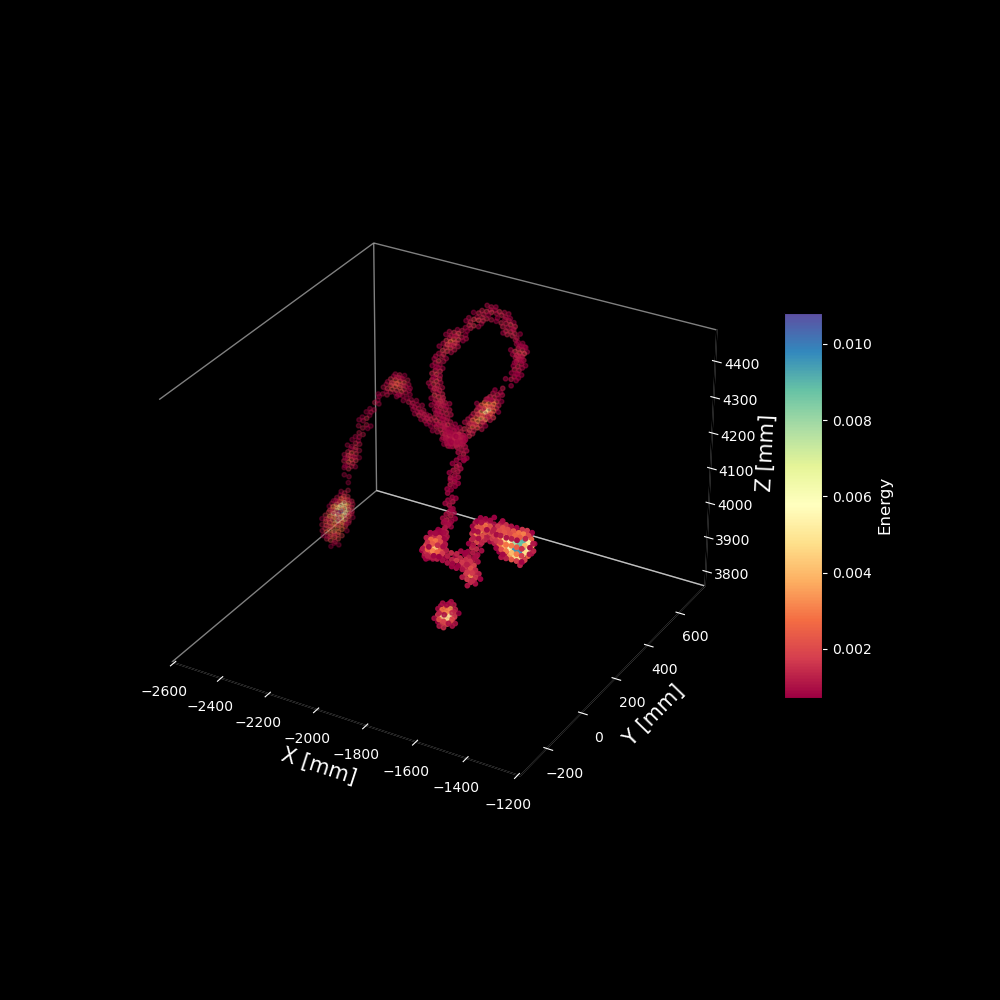

In [129]:
fig  = plt.figure(figsize=(10,10))

# Create 3D axes
ax = fig.add_subplot(111, projection='3d')

fig.set_facecolor('black')
ax.set_facecolor('black')

# Scatter plot in 3D

cut_df = df_smear_merge[df_smear_merge.energy > 0.0007]

sc = ax.scatter(cut_df.x, cut_df.y, cut_df.z, 
                c=cut_df.energy, cmap='Spectral', s=10, label="Reco hits")

ax.set_xlabel("X [mm]", fontsize=15, color='white')
ax.set_ylabel("Y [mm]", fontsize=15, color='white')
ax.set_zlabel("Z [mm]", fontsize=15, color='white')

# Set the color of the axes labels and ticks to white
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')

# ax.set_title(title, fontsize=15, color='white')

# Set dark theme
ax.xaxis.pane.set_edgecolor("white")
ax.yaxis.pane.set_edgecolor("white")
ax.zaxis.pane.set_edgecolor("white")
ax.grid(False)

# Add colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Energy", fontsize=12, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Remove background (axis)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False